# CLAM (CNN + LSTM + Attention Model) for Stock Forecasting

## Overview

This project builds a robust stock price forecasting model trained on more than 100 tickers across multiple sectors. It forecasts both:

- **Long-term trends** (quarter-level, e.g., next 65 trading days)
- **Short-term movements** (hour-level, e.g., next 7 hours)

The architecture is based on the **CLAM model**, which combines:
- Convolutional Neural Networks (CNN) for local pattern extraction
- Long Short-Term Memory (LSTM) for temporal dependencies
- Attention mechanism for adaptive focus on key time steps

---

## Model Architecture

### Input Features
- Features: `Open`, `High`, `Low`, `Close`, `Volume` (total of 5)
- Input length:
  - Long-term: 252 trading days (1 year)
  - Short-term: 140 hours (20 trading days of hourly data)

### Why This Architecture?

| Layer | Purpose |
|-------|---------|
| **CNN** | Captures local patterns and price shifts over short windows |
| **LSTM** | Models long-range temporal dependencies in price data |
| **Attention** | Focuses the model on important historical time steps for better interpretability and performance |
| **LayerNormalization & Dropout** | Ensures training stability and prevents overfitting |
| **RepeatVector & TimeDistributed(Dense)** | Expands the encoded context for forecasting over future time steps |

---

## Mathematical Formulation

### 1D Convolution

$$
h_t = \text{ReLU}(W * x_t + b)
$$

### LSTM Equations

$$
\begin{align*}
f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \\
o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
h_t &= o_t * \tanh(C_t)
\end{align*}
$$

### Attention Mechanism

$$
\begin{align*}
e_t &= \tanh(Wx_t + b) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_{t'} \exp(e_{t'})} \\
\text{Context Vector } c &= \sum_{t} \alpha_t \cdot x_t
\end{align*}
$$

The attention layer computes weights $$\alpha_t$$ over all time steps and forms a weighted sum (context vector) that represents the important features for forecasting.

---

## Training Configuration

### Loss Function: Huber Loss

Huber Loss combines the advantages of both MAE and MSE:

- **For small errors**: behaves like **MSE**, encouraging precision
- **For large errors (outliers)**: behaves like **MAE**, preventing instability

Mathematically:

$$
L_\delta(a) = 
\begin{cases}
\frac{1}{2}a^2 & \text{for } |a| \leq \delta \\
\delta(|a| - \frac{1}{2}\delta) & \text{otherwise}
\end{cases}
$$

* This makes it ideal for **volatile stock market data**, allowing robust yet fine-grained learning.

### Optimizer: AdamW

AdamW (Adam with decoupled weight decay) enhances the classic Adam optimizer by decoupling L2 regularization (weight decay) from gradient-based updates.

- Regularizes better than Adam when networks are **deep and complex** (like CNN + LSTM stacks)
- Offers **better generalization** in noisy, high-volatility datasets
- Prevents overfitting more effectively by directly penalizing large weights

## Evaluation Metric: Directional Accuracy

We don't just care about price precision — we care whether the model **predicts the correct direction** (up/down) of price change.

## Trading Setup

| Simulation Mode | Input Length | Forecast Horizon | CNN Layers | LSTM Layers | Notes |
|------------------|---------------|-------------------|-------------|---------------|-------|
| **Quarterly (Long-Term)** | 252 trading days | 65 trading days (~3 months) | 3 layers (128 filters, kernel size = 5) | 3 layers (256 units) | Weekly training (e.g. every Sunday) |
| **Hourly (Short-Term)**   | 140 hours (~20 trading days) | 7 hours (1 trading day)     | 2 layers (64 filters, kernel size = 3)  | 2 layers (128 units) | Daily training (e.g. every evening) |

> The long-term model learns slow-moving macro trends, while the short-term model captures microstructure behavior for intraday trading.

---

## Output Interpretation

When a stock ticker is passed into the trained **CLAM forecasting pipeline**, the following are produced:

- **Predicted Closing Prices** for each future time step (up to 65 days or 7 hours)
- **Expected Growth Rate** calculated as:

  $$
  \text{Growth} = \frac{\text{Final Forecasted Close} - \text{Current Close}}{\text{Current Close}} \times 100\%
  $$

- **Directional Accuracy**: Measures whether the model predicts the correct movement direction (up/down)
- **Visualization** of historical and forecasted prices:
    - Blue Line → Historical closing prices
    - Orange Dashed Line → Forecasted closing prices
    - Red Dot → Current price (annotated with price and date)
    - Green Dot → Final predicted price (annotated with price and date)

---

## Summary

The CLAM (CNN + LSTM + Attention Model) is a powerful hybrid architecture designed specifically for forecasting financial time series:

- **CNN** layers capture short-term local trends and patterns
- **LSTM** layers model longer-term sequential dependencies
- **Attention** allows the model to focus on the most informative time steps dynamically
- **Huber Loss** enables robustness against outliers while maintaining smooth convergence
- **AdamW Optimizer** prevents overfitting and promotes generalization on unseen data

> This model is ideal for forecasting both long-term investment trends and short-term trading signals across a wide range of tickers. It empowers systematic trading strategies with deep learning intelligence.

In [ ]:
# train_model.py
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, Layer, RepeatVector, TimeDistributed, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tqdm import tqdm
import datetime
import joblib

"""  
Model configuration guidelines:

* Long term (Quarterly): 
  - Training Frequency: Weekly (e.g., every Sunday night)
  - SEQ_LENGTH = 252 (about 1 trading year of input)
  - FORECAST_DAYS = 65 (approx. 3 months prediction horizon)
  - CNN: 3 layers, 128 filters, kernel_size = 5
  - LSTM: 3 layers, 256 units

* Short term (Hourly): 
  - Training Frequency: Daily (e.g., every night after market close)
  - SEQ_LENGTH = 140 (about 140 hours (20 days) of input)
  - FORECAST_STEPS = 7 (next 7 hours prediction)
  - CNN: 2 layers, 64 filters, kernel_size = 3
  - LSTM: 2 layers, 128 units
"""
# Configuration for model training and prediction
CONFIG = {
    'quarterly': {
        'seq_length': 252,
        'forecast_horizon': 65,
        'interval': '1d', # Daily data
        'cnn_layers': [
            {'filters': 128, 'kernel_size': 5},
            {'filters': 128, 'kernel_size': 5},
            {'filters': 128, 'kernel_size': 5}
        ],
        'lstm_layers': [
            {'units': 256},
            {'units': 256},
            {'units': 256}
        ],
        'data_start_date': '2010-01-01',
        'validation_period': {'years': 2}
    },
    'hourly': {
        'seq_length': 140,
        'forecast_horizon': 7,
        'interval': '1h', # Hourly data
        'cnn_layers': [
            {'filters': 64, 'kernel_size': 3},
            {'filters': 64, 'kernel_size': 3}
        ],
        'lstm_layers': [
            {'units': 128},
            {'units': 128}
        ],
        # yfinance provides max 730 days of hourly data
        'data_start_date': (datetime.date.today() - datetime.timedelta(days=729)).strftime('%Y-%m-%d'),
        'validation_period': {'months': 3}
    }
}
FEATURE_COUNT = 5 # Open, High, Low, Close, Volume

# Custom Attention layer and custom metric (Directional Accuracy)
@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs): super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Weight matrix for attention scoring
        self.W = self.add_weight(name='att_w', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True) 
        # Bias term
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Attention scores
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(K.squeeze(e, axis=-1))
        # Weighted sum to generate context vector
        context = K.sum(x * K.expand_dims(alpha, axis=-1), axis=1)
        return context

# Measures accuracy of predicted price movement direction
def directional_accuracy(y_true, y_pred):
    # Compare the sign of predicted vs actual Close price changes
    true_direction = K.sign(y_true[:, :, 3]) # Close is the 4th feature (index 3)
    pred_direction = K.sign(y_pred[:, :, 3])
    correct_direction = K.equal(true_direction, pred_direction)
    return K.mean(tf.cast(correct_direction, tf.float32))

# Model creation function
def create_model(config):
    seq_len = config['seq_length']
    forecast_horizon = config['forecast_horizon']
    
    encoder_inputs = Input(shape=(seq_len, FEATURE_COUNT))
    x = encoder_inputs

    # Build CNN layers dynamically
    for layer_params in config['cnn_layers']:
        x = Conv1D(filters=layer_params['filters'], kernel_size=layer_params['kernel_size'], padding='causal', activation='relu')(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)

    # Build LSTM layers dynamically
    for layer_params in config['lstm_layers']:
        x = LSTM(units=layer_params['units'], return_sequences=True)(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
    
    # Attention context vector
    context_vector = Attention()(x)

    # Decoder for sequence forecasting
    decoder_lstm_units = config['lstm_layers'][-1]['units']
    decoder_inputs = RepeatVector(forecast_horizon)(context_vector)
    decoder_lstm = LSTM(decoder_lstm_units, return_sequences=True)(decoder_inputs)
    outputs = TimeDistributed(Dense(FEATURE_COUNT))(decoder_lstm)
    
    model = Model(encoder_inputs, outputs)

    # Compile with custom metric
    # The Huber loss function and the AdamW optimizer are the best combination for stock data with high volatility and many unpredictable outliers
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), 
                  loss='huber', 
                  metrics=[directional_accuracy])
    return model

# Sliding window sequence generation
def create_sequences(data, seq_len, forecast_len):
    X, y = [], []
    for i in range(len(data) - seq_len - forecast_len + 1):
        X.append(data[i:(i + seq_len)])
        y.append(data[(i + seq_len):(i + seq_len + forecast_len)])
    return np.array(X), np.array(y)


# Main training loop (Modify)
def main(model_type, training_end_date=None):
    print(f"Starting training for [{model_type.upper()}] model")
    
    # Load the correct configuration
    config = CONFIG[model_type]
    seq_length = config['seq_length']
    forecast_horizon = config['forecast_horizon']
    
    # Training tickers (multi-sector, 100+ tickers)
    TRAINING_TICKERS = [
        # Technology
        'AAPL',  # Apple
        'MSFT',  # Microsoft
        'GOOGL', # Alphabet (Google)
        'NVDA',  # NVIDIA
        'AVGO',  # Broadcom
        'ORCL',  # Oracle
        'ADBE',  # Adobe
        'CRM',   # Salesforce
        'CSCO',  # Cisco Systems
        'AMD',   # Advanced Micro Devices
        'INTC',  # Intel
        'QCOM',  # Qualcomm
        'IBM',   # IBM
        'TXN',   # Texas Instruments
        'AMAT',  # Applied Materials
        'MU',    # Micron Technology
        'LRCX',  # Lam Research
        'ADI',   # Analog Devices
        'SNPS',  # Synopsys
        'CDNS',  # Cadence Design Systems

        # Financials
        'JPM',   # JPMorgan Chase
        'BAC',   # Bank of America
        'WFC',   # Wells Fargo
        'GS',    # Goldman Sachs
        'MS',    # Morgan Stanley
        'C',     # Citigroup
        'BLK',   # BlackRock
        'SPGI',  # S&P Global
        'AXP',   # American Express
        'V',     # Visa
        'MA',    # Mastercard
        'PYPL',  # PayPal
        'SCHW',  # Charles Schwab
        'PNC',   # PNC Financial Services
        'USB',   # U.S. Bancorp

        # Healthcare
        'JNJ',   # Johnson & Johnson
        'UNH',   # UnitedHealth Group
        'LLY',   # Eli Lilly
        'PFE',   # Pfizer
        'MRK',   # Merck & Co.
        'ABBV',  # AbbVie
        'TMO',   # Thermo Fisher Scientific
        'DHR',   # Danaher
        'AMGN',  # Amgen
        'GILD',  # Gilead Sciences
        'MDT',   # Medtronic
        'ISRG',  # Intuitive Surgical
        'SYK',   # Stryker
        'BSX',   # Boston Scientific
        'CI',    # Cigna

        # Consumer
        'AMZN',  # Amazon
        'TSLA',  # Tesla
        'WMT',   # Walmart
        'COST',  # Costco
        'HD',    # Home Depot
        'MCD',   # McDonald's
        'NKE',   # Nike
        'SBUX',  # Starbucks
        'TGT',   # Target
        'LOW',   # Lowe's
        'KO',    # Coca-Cola
        'PEP',   # PepsiCo
        'PG',    # Procter & Gamble
        'CL',    # Colgate-Palmolive
        'KMB',   # Kimberly-Clark
        'GIS',   # General Mills
        'F',     # Ford Motor
        'GM',    # General Motors
        'DIS',   # Disney
        'NFLX',  # Netflix

        # Industrials 
        'CAT',   # Caterpillar
        'BA',    # Boeing
        'LMT',   # Lockheed Martin
        'RTX',   # RTX Corporation (Raytheon)
        'HON',   # Honeywell
        'UNP',   # Union Pacific
        'UPS',   # United Parcel Service
        'FDX',   # FedEx
        'DE',    # Deere & Company
        'GE',    # General Electric
        'MMM',   # 3M
        'GD',    # General Dynamics
        'NOC',   # Northrop Grumman
        'WM',    # Waste Management
        'ETN',   # Eaton Corporation

        # Energy
        'XOM',   # Exxon Mobil
        'CVX',   # Chevron
        'SHEL',  # Shell
        'COP',   # ConocoPhillips
        'SLB',   # Schlumberger
        'EOG',   # EOG Resources
        'MPC',   # Marathon Petroleum
        'VLO',   # Valero Energy
        'PSX',   # Phillips 66
        'OXY',   # Occidental Petroleum
        'HAL',   # Halliburton
        'KMI',   # Kinder Morgan
        'WMB',   # Williams Companies
        'DVN'    # Devon Energy
    ]

    # Data download and preprocessing
    all_processed_dfs = []
    failed_tickers = []
    
    # Modify
    end_date = pd.to_datetime(training_end_date) if training_end_date else pd.Timestamp.now()
    
    for ticker in tqdm(TRAINING_TICKERS, desc="Processing Tickers"):
        try:
            raw_df = yf.download(ticker, 
                                 start=config['data_start_date'], 
                                 end=end_date, 
                                 interval=config['interval'], 
                                 progress=False,
                                 auto_adjust=False)
            if raw_df.empty: raise ValueError("No data from yfinance.")


            processed_df = pd.DataFrame(index=raw_df.index)
            processed_df['Open'] = np.log(raw_df['Open']).diff()
            processed_df['High'] = np.log(raw_df['High']).diff()
            processed_df['Low'] = np.log(raw_df['Low']).diff()
            processed_df['Close'] = np.log(raw_df['Close']).diff()
            processed_df['Volume'] = np.log1p(raw_df['Volume']).diff()

            # Drop initial NaN rows caused by diff()
            processed_df.dropna(inplace=True)
            all_processed_dfs.append(processed_df)
        except Exception as e:
            failed_tickers.append(ticker)

    if not failed_tickers: 
        print("All tickers processed successfully!")
    else: 
        print(f"Failed to process: {failed_tickers}")

    # Merge all tickers and sort by date
    full_processed_df = pd.concat(all_processed_dfs).sort_index()

    # Data splitting
    last_date = full_processed_df.index.max()
    split_date = last_date - pd.DateOffset(**config['validation_period'])
    train_df = full_processed_df[full_processed_df.index < split_date]
    val_df = full_processed_df[full_processed_df.index >= split_date]
    
    print(f"Training data period: {train_df.index.min()} ~ {train_df.index.max()}")
    print(f"Validation data period: {val_df.index.min()} ~ {val_df.index.max()}")

    # Scaling and Sequencing
    scaler = MinMaxScaler(feature_range=(-1, 1))    # Use (-1,1) since returns can be negative
    scaler.fit(train_df)
    train_scaled = scaler.transform(train_df)
    val_scaled = scaler.transform(val_df)
    
    # Generate sequences
    X_train, y_train = create_sequences(train_scaled, seq_length, forecast_horizon)
    X_val, y_val = create_sequences(val_scaled, seq_length, forecast_horizon)

    # Build and train model
    model = create_model(config)
    model.summary()
    
    callbacks = [
        # Save the best model based on directional accuracy
        EarlyStopping(monitor='val_directional_accuracy', mode='max', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
    ]
    
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

    # Save Artifacts
    model_filename = f"{model_type}_model.h5"
    scaler_filename = f"{model_type}_scaler.pkl"
    model.save(model_filename)
    joblib.dump(scaler, scaler_filename)
    print(f"\nTraining complete. {model_filename} and {scaler_filename} have been saved.")

if __name__ == '__main__':
    historical_training_date = '2025-07-01'
    # To train a different model, options are 'quarterly' or 'hourly'
    model_to_train = 'hourly' 
    print(f"Starting notebook training for the '{model_to_train}' model.")
    main(model_to_train, training_end_date=historical_training_date)

Starting notebook training for the 'hourly' model.
Starting training for [HOURLY] model


Processing Tickers: 100%|██████████| 99/99 [00:35<00:00,  2.82it/s]


All tickers processed successfully!
Training data period: 2023-08-22 14:30:00+00:00 ~ 2025-03-28 19:30:00+00:00
Validation data period: 2025-03-31 13:30:00+00:00 ~ 2025-06-30 19:30:00+00:00


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 140, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 140, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_34          │ (None, 140, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 140, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_35          │ (None, 140, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 140, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_36          │ (None, 140, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 140, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 140, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_37          │ (None, 140, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 140, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_7 (Attention)         │ (None, 128)            │           268 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 7, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 7, 5)           │           645 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,041 (1.44 MB)

 Trainable params: 377,041 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8649/8649 ━━━━━━━━━━━━━━━━━━━━ 492s 56ms/step - directional_accuracy: 0.9997 - loss: 4.2500e-04 - val_directional_accuracy: 0.9985 - val_loss: 6.1261e-04 - learning_rate: 1.0000e-04
Epoch 2/100
2136/8649 ━━━━━━━━━━━━━━━━━━━━ 6:33 60ms/step - directional_accuracy: 0.9997 - loss: 3.4380e-04

Successfully loaded model (hourly_model.h5) and scaler.

Starting model prediction hourly (reference date: 2025-07-01).


Predicting (hourly): 100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Top 10 Predictions for Next 7 Hours
 Rank Ticker Current Close Predicted Close  Actual Accuracy (%) Expected Growth
    1   WULF         $4.37           $4.40   $5.04       87.37%           0.77%
    2    SMR        $39.53          $39.64  $35.20       87.39%           0.28%
    3   RKLB        $35.74          $35.75  $35.69       99.85%           0.01%
    4  GOOGL       $176.20         $176.13 $178.63       98.60%          -0.04%
    5    MCD       $292.12         $291.76 $294.60       99.04%          -0.12%
    6    UNP       $230.05         $229.36 $237.08       96.74%          -0.30%
    7   IONQ        $43.00          $42.81  $44.75       95.66%          -0.45%
    8    JNJ       $152.68         $151.92 $155.55       97.66%          -0.50%
    9   TSLA       $317.62         $315.99 $315.65       99.89%          -0.51%
   10   SMCI        $49.00          $48.75  $48.73       99.97%          -0.52%


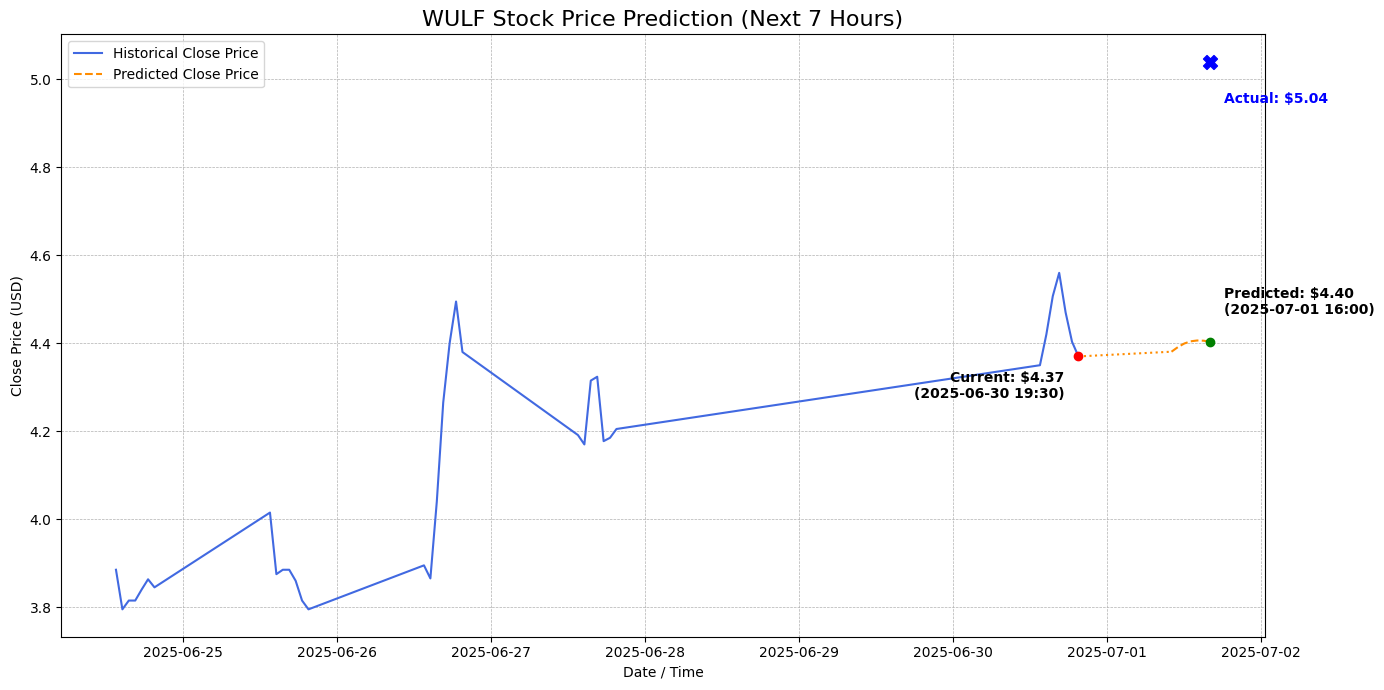

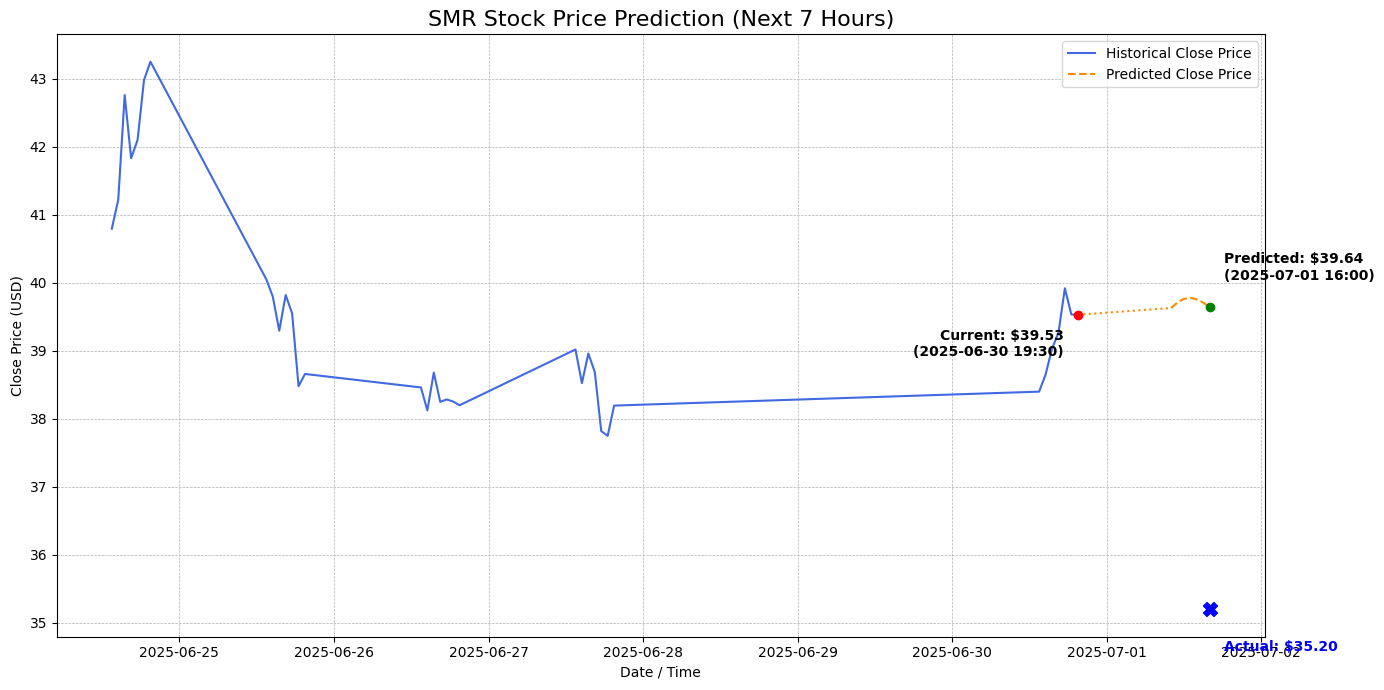

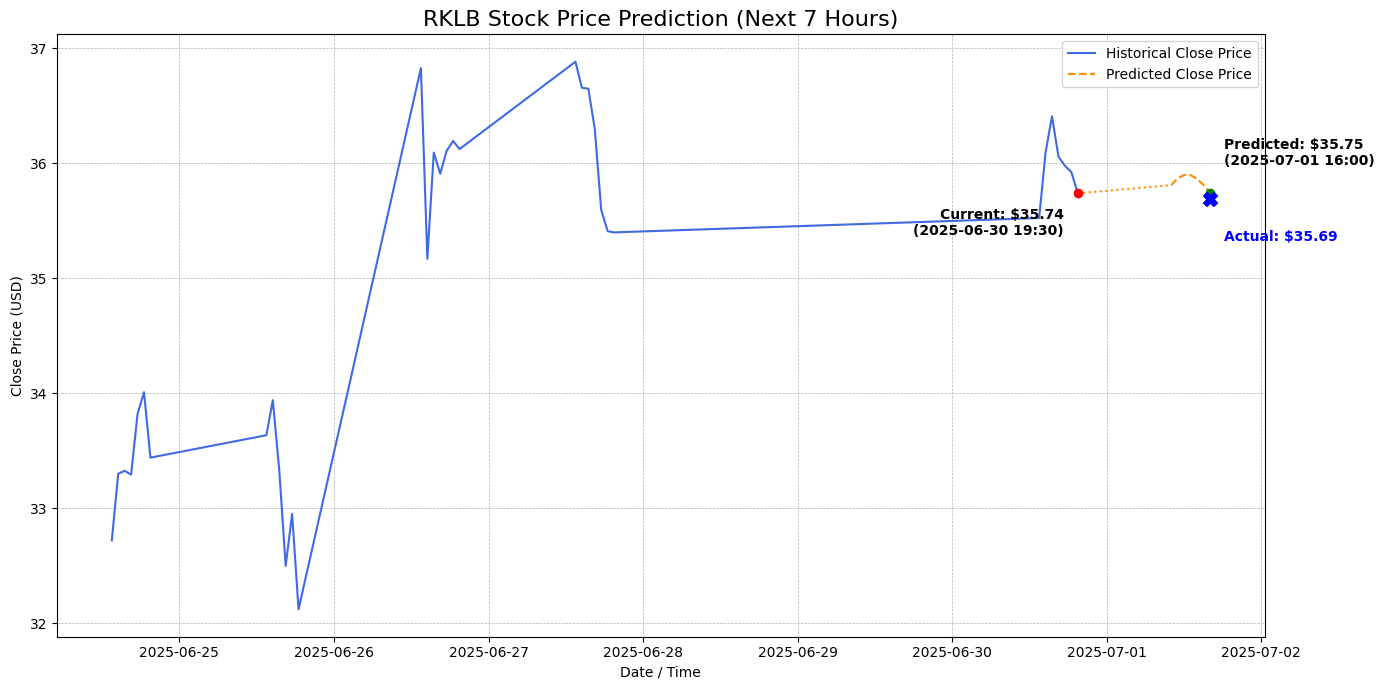

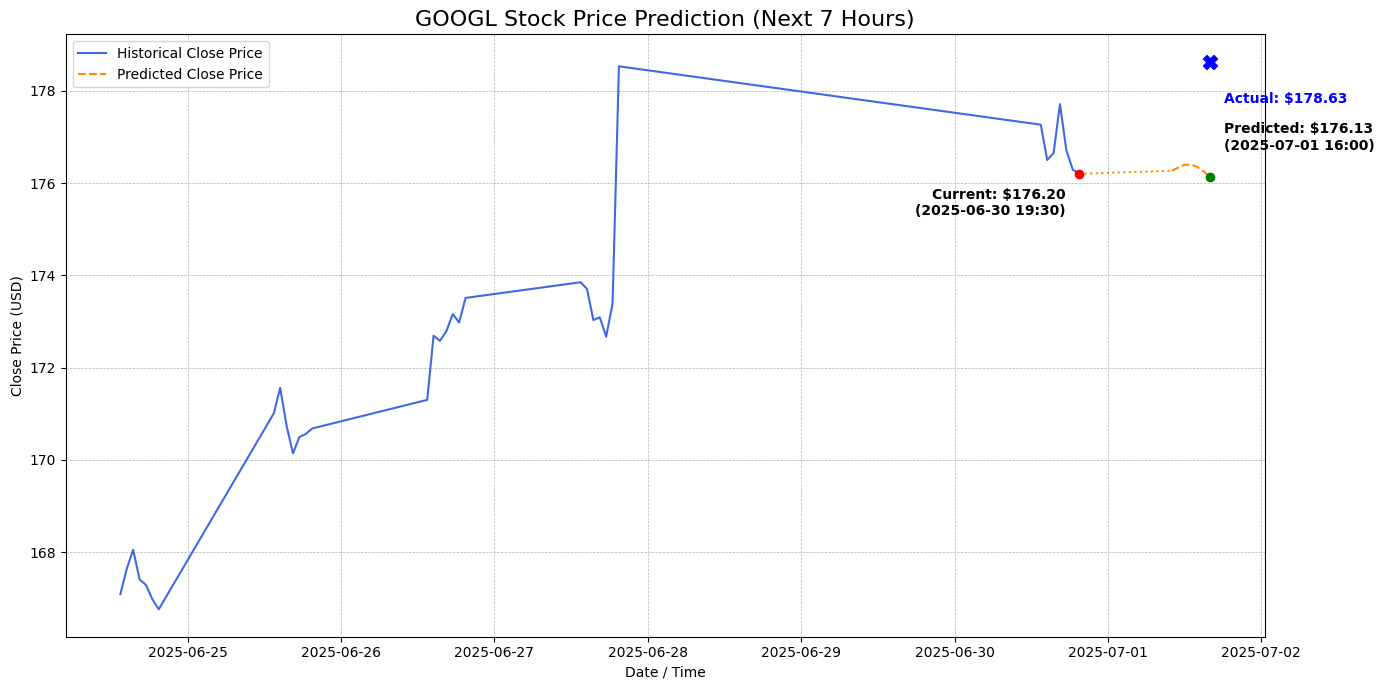

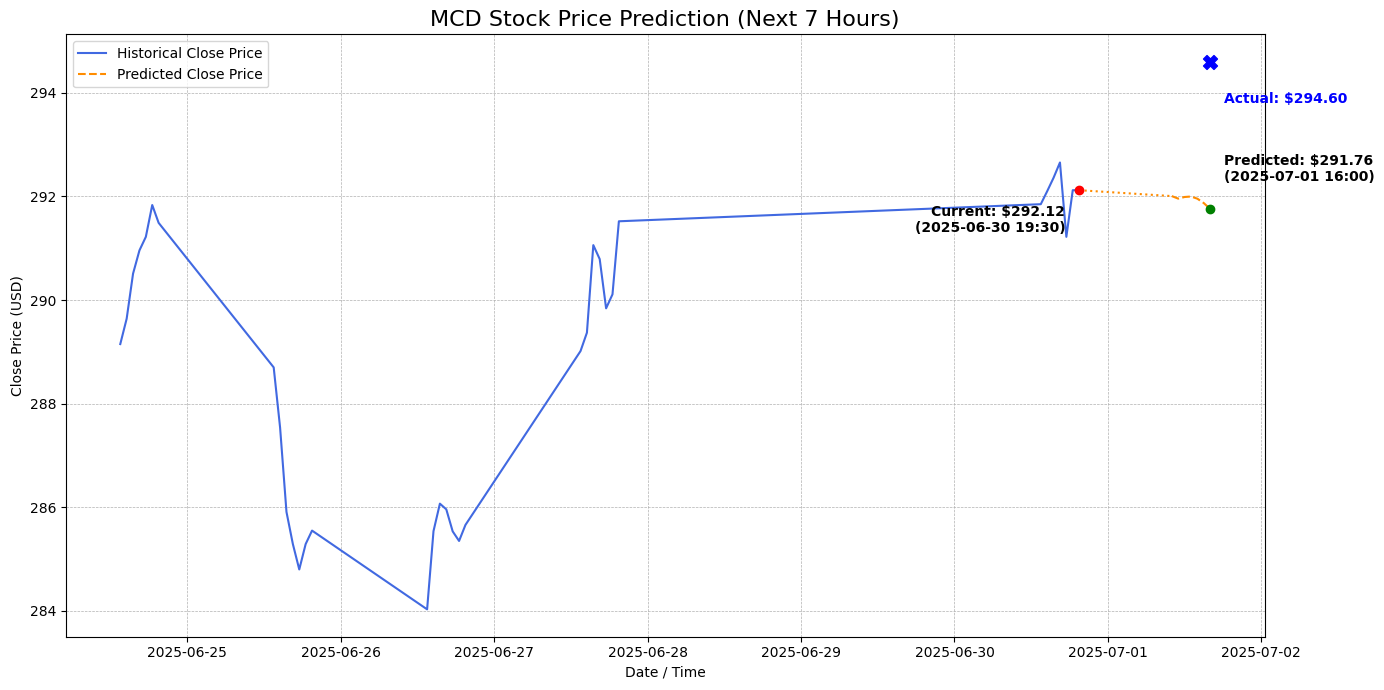

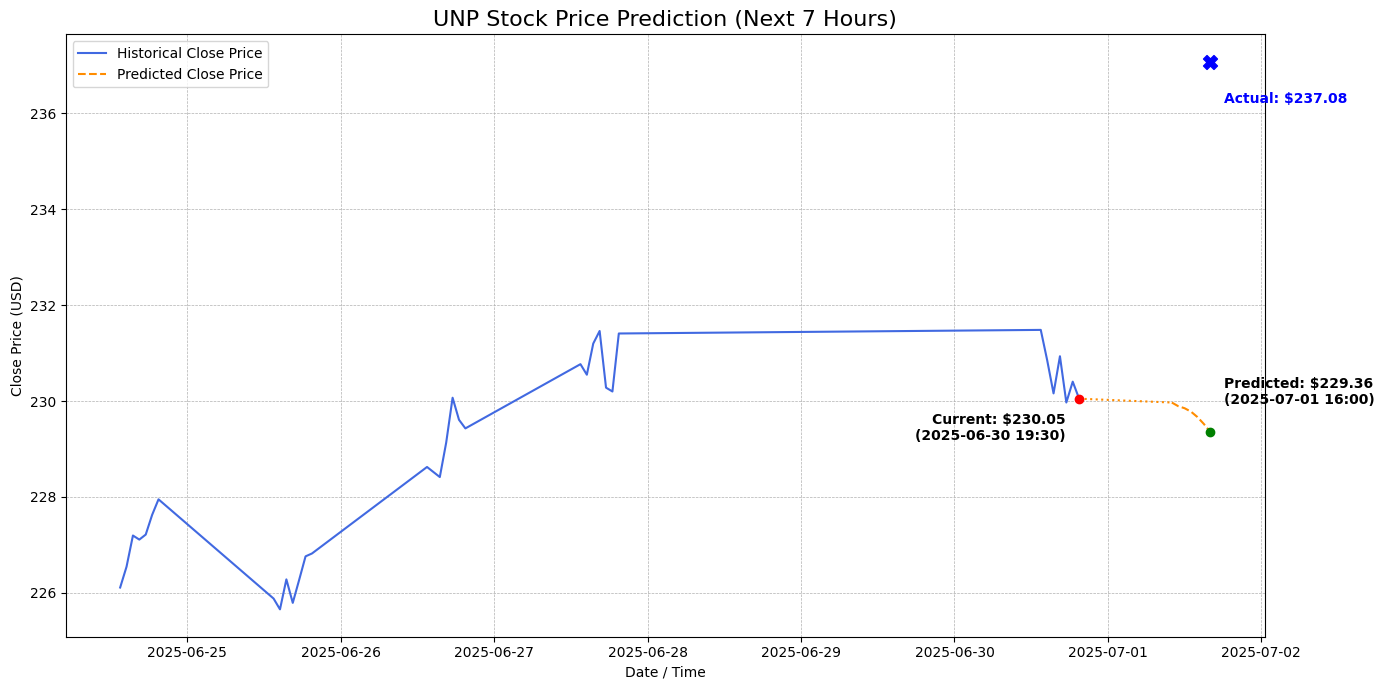

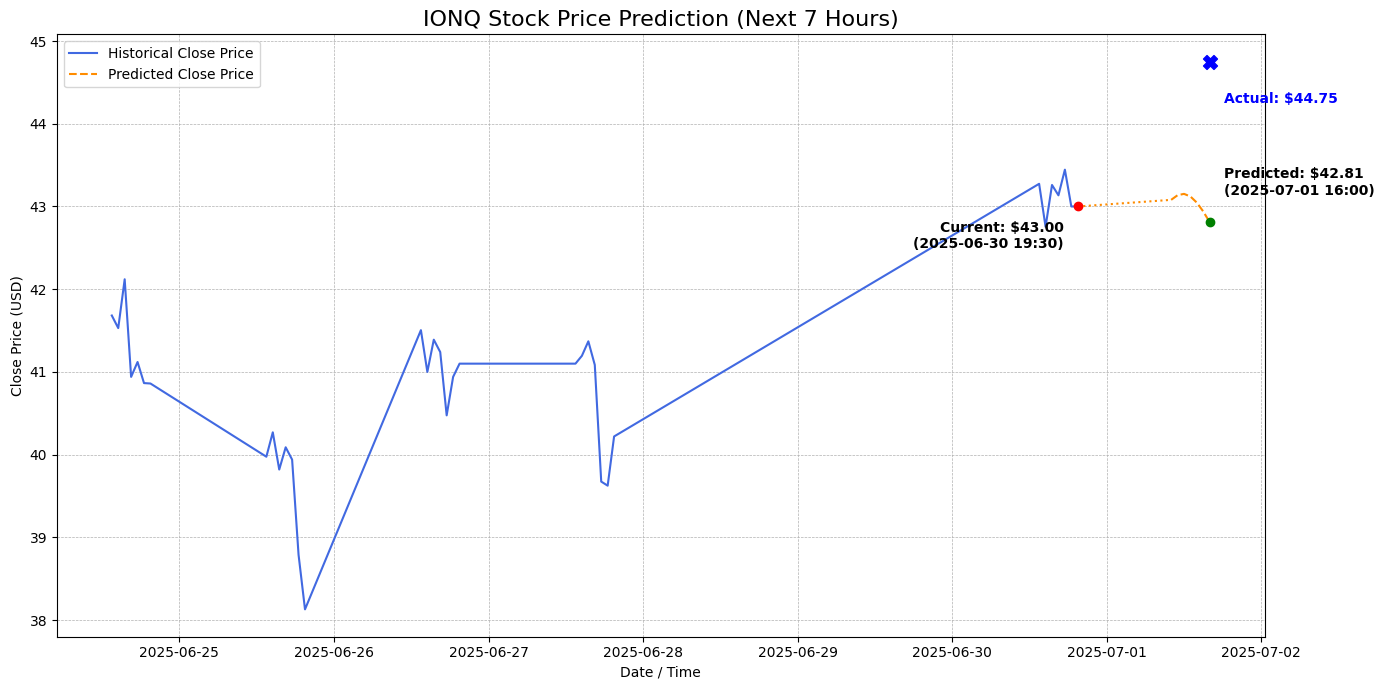

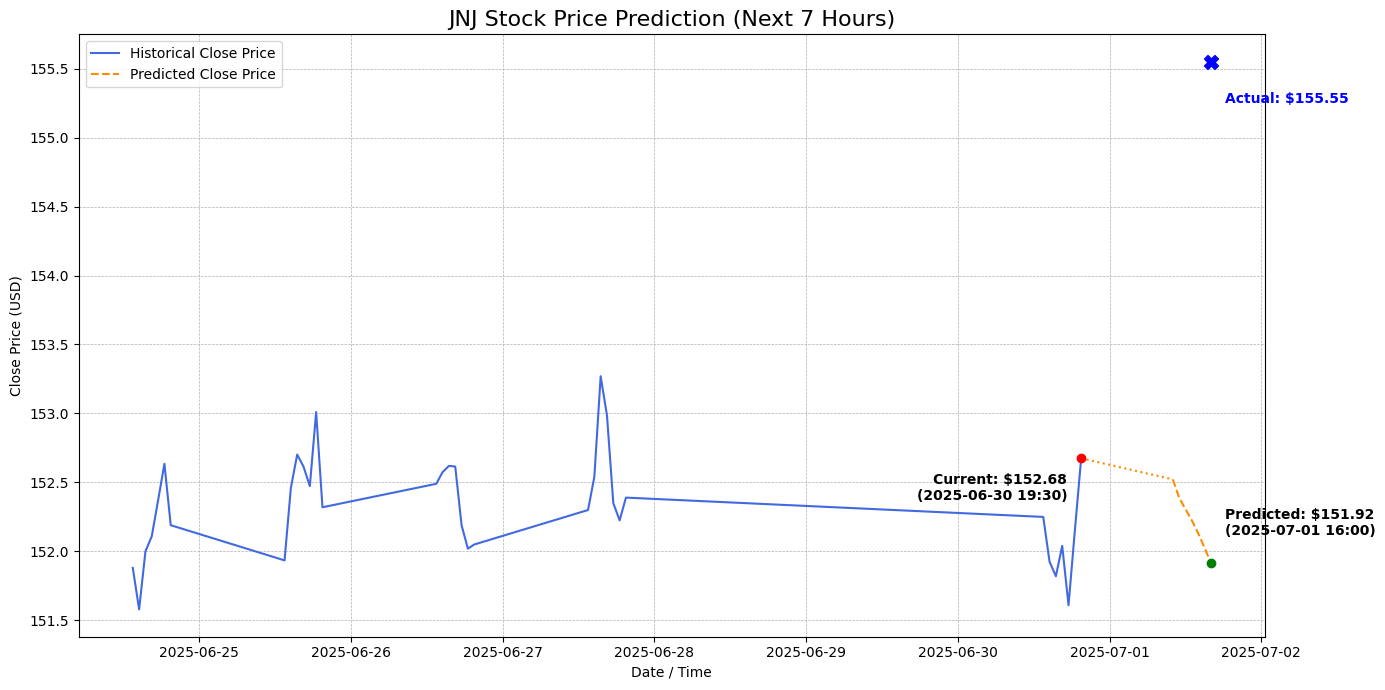

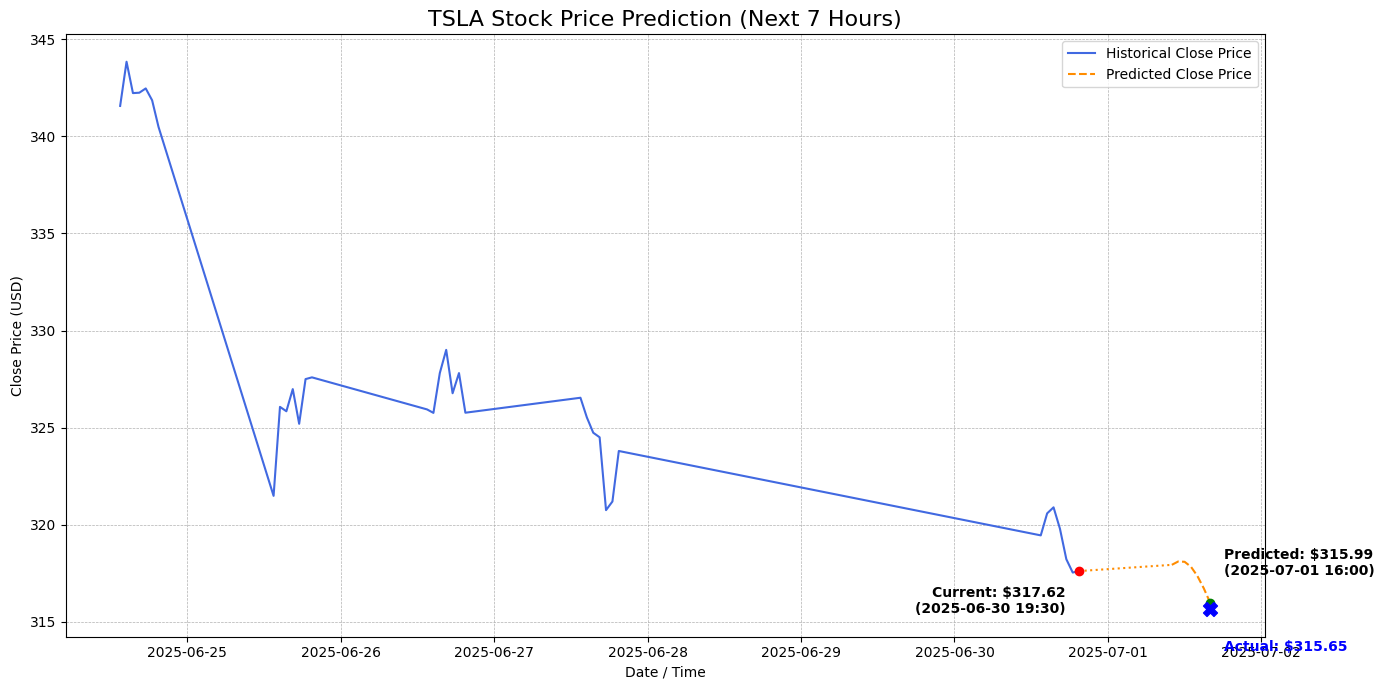

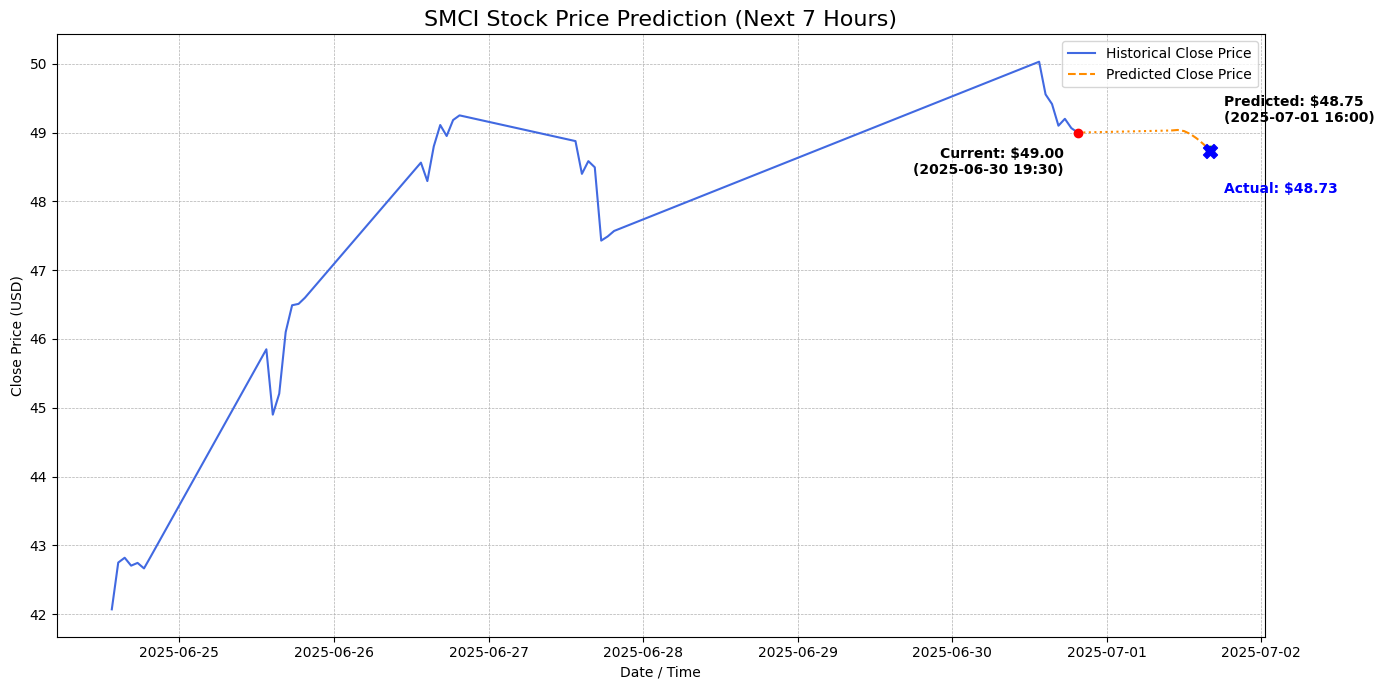

In [ ]:
# workflow.py
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# Configuration for model training and prediction
CONFIG = {
    'quarterly': {
        'seq_length': 252,
        'forecast_horizon': 65,
        'interval': '1d',
        'model_path': 'quarterly_model.h5',
        'scaler_path': 'quarterly_scaler.pkl',
        'plot_history_points': 120 # Plot last 120 days
    },
    'hourly': {
        'seq_length': 140,
        'forecast_horizon': 7,
        'interval': '1h',
        'model_path': 'hourly_model.h5',
        'scaler_path': 'hourly_scaler.pkl',
        'plot_history_points': 35 # Plot last 35 hours (5 trading days)
    }
}
FEATURE_COUNT = 5 # Open, High, Low, Close, Volume

# Attention and directional_accuracy are redefined to load exactly the same as the trained model
@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_w', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=False)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=False)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        alpha = K.softmax(K.squeeze(e, axis=-1))
        context = K.sum(x * K.expand_dims(alpha, axis=-1), axis=1)
        return context

def directional_accuracy(y_true, y_pred):
    true_direction = K.sign(y_true[:, :, 3]) 
    pred_direction = K.sign(y_pred[:, :, 3])
    correct_direction = K.equal(true_direction, pred_direction)
    return K.mean(tf.cast(correct_direction, tf.float32))

def load_prediction_tools(config):
    """Loads the correct model and scaler based on the configuration."""
    try:
        custom_objects = {'Attention': Attention, 'directional_accuracy': directional_accuracy}
        model = load_model(config['model_path'], custom_objects=custom_objects)
        scaler = joblib.load(config['scaler_path'])
        print(f"Successfully loaded model ({config['model_path']}) and scaler.")
        return model, scaler
    except Exception as e:
        print(f"Error loading model/scaler: {e}")
        return None, None

# (Modify)
def predict_single_ticker(ticker, model, scaler, config, prediction_date=None):
    """Dynamically fetches data and predicts for a single ticker."""
    try:
        seq_length = config['seq_length']
        interval = config['interval']

        # Determine the end date for fetching historical data
        end_date = pd.to_datetime(prediction_date) if prediction_date else pd.Timestamp.now()

        # Calculate how many calendar days of data to download
        if interval == '1d':
            days_to_download = int(seq_length * 1.6) + 10
            start_date = end_date - pd.DateOffset(days=days_to_download)
        elif interval == '1h':
            days_to_download = int(seq_length / 7 * 1.5) + 5
            start_date = end_date - pd.DateOffset(days=days_to_download)

        raw_df = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
        
        if len(raw_df) < seq_length: 
            return None

        # Save last actual closing price for later reconstruction of absolute predictions
        last_real_close = float(raw_df['Close'].iloc[-1])
        
        processed_df = pd.DataFrame(index=raw_df.index)
        processed_df['Open'] = np.log(raw_df['Open']).diff()
        processed_df['High'] = np.log(raw_df['High']).diff()
        processed_df['Low'] = np.log(raw_df['Low']).diff()
        processed_df['Close'] = np.log(raw_df['Close']).diff()
        processed_df['Volume'] = np.log1p(raw_df['Volume']).diff()
        processed_df.dropna(inplace=True)

        # Prepare last sequence for prediction
        last_sequence_processed = processed_df.iloc[-seq_length:].values
        last_sequence_scaled = scaler.transform(last_sequence_processed)

        # Model input shape: (samples, sequence_length, features)
        X_pred = np.expand_dims(last_sequence_scaled, axis=0)

        # Run prediction
        predicted_scaled = model.predict(X_pred, verbose=0)

        # Reverse scaling
        predicted_processed = scaler.inverse_transform(predicted_scaled[0])
        
        # Reverse log-diff transformation
        predicted_closes = []
        current_log_close = np.log(last_real_close)
        for log_diff in predicted_processed[:, 3]:  # Column index 3 = Close
            current_log_close += log_diff
            predicted_closes.append(np.exp(current_log_close))
        
        # Compute expected growth
        final_predicted_close = predicted_closes[-1]
        growth_rate = (final_predicted_close - last_real_close) / last_real_close

        # Get actual future close price
        actual_future_close = None
        forecast_horizon = config['forecast_horizon']

        # Get actual future close price
        if interval == '1d':
            # Get future data for 65 days
            future_start_date = end_date + pd.Timedelta(days=1)
            future_end_date = future_start_date + pd.DateOffset(days=forecast_horizon * 1.6)
            future_df = yf.download(ticker, 
                                    start=future_start_date, 
                                    end=future_end_date, 
                                    interval='1d', 
                                    progress=False, 
                                    auto_adjust=False)           
            if len(future_df) >= forecast_horizon:
                actual_future_close = float(future_df['Close'].iloc[forecast_horizon - 1])

        else: # '1h'
            # Get future data for the next trading day
            future_start_date = (end_date + pd.Timedelta(days=1)).normalize()
            future_end_date = future_start_date + pd.Timedelta(days=4) # Consider weekends
            future_df = yf.download(ticker, 
                                    start=future_start_date, 
                                    end=future_end_date, 
                                    interval='1h', 
                                    progress=False, 
                                    auto_adjust=False)
            if not future_df.empty:
                # Get the last close price at the 7th hour of the day
                if len(future_df) >= forecast_horizon:
                    actual_future_close = float(future_df['Close'].iloc[forecast_horizon - 1])

        return {'ticker': ticker, 
                'growth_rate': growth_rate, 
                'last_real_close': last_real_close,
                'historical_data': raw_df, 
                'predicted_closes': predicted_closes,
                'actual_future_close': actual_future_close} 
    
    except Exception as e:
        return None

# (Modify)
def plot_prediction(result, config):
    """Dynamically plots results for either daily or hourly predictions."""
    historical_df = result['historical_data']

    # Create date index for forecast horizon
    last_timestamp = historical_df.index[-1]
    forecast_horizon = config['forecast_horizon']
    
    # Create future timestamps
    if config['interval'] == '1d':
        future_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(days=1), periods=forecast_horizon, freq='B') # B for Business Day
        time_unit = "Days"
        date_format = '%Y-%m-%d'
    else: # '1h'
        # Find the next trading day and create hourly timestamps
        next_day = last_timestamp.normalize() + pd.Timedelta(days=1)
        if next_day.weekday() == 5: # Saturday
            next_day += pd.Timedelta(days=2)
        elif next_day.weekday() == 6: # Sunday
            next_day += pd.Timedelta(days=1)


        # Assume US market hours 9:30 -> 16:00
        future_timestamps = pd.to_datetime([next_day.replace(hour=h) for h in range(10, 10 + forecast_horizon)])
        time_unit = "Hours"
        date_format = '%Y-%m-%d %H:%M'

    plt.figure(figsize=(14, 7))
    
    # Plot historical and predicted data
    plt.plot(historical_df.index[-config['plot_history_points']:], historical_df['Close'][-config['plot_history_points']:], label='Historical Close Price', color='royalblue')
    plt.plot(future_timestamps, result['predicted_closes'], label='Predicted Close Price', color='darkorange', linestyle='--')
    plt.plot([last_timestamp, future_timestamps[0]], [result['last_real_close'], result['predicted_closes'][0]], color='darkorange', linestyle=':')
    
    # Annotations
    current_price = result['last_real_close']
    plt.scatter(last_timestamp, current_price, color='red', zorder=5)
    plt.annotate(f'Current: ${current_price:.2f}\n({last_timestamp.strftime(date_format)})', (last_timestamp, current_price), textcoords="offset points", xytext=(-10, -30), ha='right', fontweight='bold')
    
    predicted_price = result['predicted_closes'][-1]
    plt.scatter(future_timestamps[-1], predicted_price, color='green', zorder=5)
    plt.annotate(f'Predicted: ${predicted_price:.2f}\n({future_timestamps[-1].strftime(date_format)})', (future_timestamps[-1], predicted_price), textcoords="offset points", xytext=(10, 20), ha='left', fontweight='bold')

    # Actual price
    actual_price = result.get('actual_future_close')
    if actual_price:
        plt.scatter(future_timestamps[-1], actual_price, color='blue', zorder=5, marker='X', s=100)
        plt.annotate(f'Actual: ${actual_price:.2f}', (future_timestamps[-1], actual_price), textcoords="offset points", xytext=(10, -30), ha='left', fontweight='bold', color='blue')

    plt.title(f"{result['ticker']} Stock Price Prediction (Next {forecast_horizon} {time_unit})", fontsize=16)
    plt.xlabel('Date / Time')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# (Modify)
def main(model_type, prediction_date=None):
    config = CONFIG[model_type]
    
    # List of tickers to analyze
    analyze_tickers = [
        'SPY', 'QQQ', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 
        'NFLX', 'AMD', 'RKLB', 'IONQ', 'SMCI', 'PLTR', 'SMR', 'LCID', 'RIVN',
        'JPM', 'BAC', 'GS', 'WFC', 'V', 'MA', 'TSM', 'ORCL', 'AVGO', 'SOFI',
        'JNJ', 'PFE', 'MRNA', 'UNH', 'LLY', 'ABBV', 'XOM', 'CVX', 'SHEL',
        'WMT', 'COST', 'TGT', 'KO', 'PEP', 'MCD', 'BA', 'CAT', 'LMT', 'DE', 'UNP',
        'RUN', 'WULF'
    ]

    model, scaler = load_prediction_tools(config)

    # Check if model and scaler are loaded successfully
    if model and scaler:
        all_results = []
        print(f"\nStarting model prediction {model_type} (reference date: {prediction_date or 'today'}).")
        for ticker in tqdm(analyze_tickers, desc=f"Predicting ({model_type})"):
            result = predict_single_ticker(ticker, model, scaler, config, prediction_date)
            if result:
                all_results.append(result)
        
        if all_results:
            ranked_results = sorted(all_results, key=lambda x: x['growth_rate'], reverse=True)
            top_10_results = ranked_results[:10]

            print(f"\nTop {len(top_10_results)} Predictions for Next {config['forecast_horizon']} { 'Days' if config['interval'] == '1d' else 'Hours'}")
            
            df_data = {
                'Rank': range(1, len(top_10_results) + 1),
                'Ticker': [r['ticker'] for r in top_10_results],
                'Current Close': [f"${r['last_real_close']:.2f}" for r in top_10_results],
                'Predicted Close': [f"${r['predicted_closes'][-1]:.2f}" for r in top_10_results],
                'Actual': [],
                'Accuracy (%)': [],
                'Expected Growth': [f"{r['growth_rate']:.2%}" for r in top_10_results]
            }
            for r in top_10_results:
                actual = r.get('actual_future_close')
                predicted = r['predicted_closes'][-1]
                if actual:
                    df_data['Actual'].append(f"${actual:.2f}")
                    accuracy = (1 - abs(actual - predicted) / actual) * 100
                    df_data['Accuracy (%)'].append(f"{accuracy:.2f}%")
                else:
                    df_data['Actual'].append("N/A")
                    df_data['Accuracy (%)'].append("N/A")

            df = pd.DataFrame(df_data)

            print(df.to_string(index=False))

            for result in top_10_results:
                plot_prediction(result, config)
    
if __name__ == '__main__':
    # Options: 'quarterly' or 'hourly'
    model_to_run = 'hourly'
    historical_date = '2025-07-01'
    
    main(model_to_run, prediction_date=historical_date)